In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
sys.path.append(os.path.abspath(os.path.join('..')))

RESULTS_DIR = "../data/results/"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [2]:
fused = pd.read_csv("../data/processed/fused_network.csv", index_col=0)
affinity = np.clip(fused.values, 0, 1)
dist_matrix = 1.0 - affinity
print(f"Distance matrix: {dist_matrix.shape}")

Distance matrix: (4153, 4153)


In [3]:
def evaluate_clustering(embedding, labels):
    """Return a dict with clustering quality metrics."""
    mask = labels != -1
    n_clusters = len(set(labels) - {-1})
    n_total = len(labels)
    n_noise = (labels == -1).sum()
    noise_pct = 100 * n_noise / n_total
    assigned_ratio = 1 - n_noise / n_total

    if n_clusters >= 2 and mask.sum() >= 2:
        sil = silhouette_score(embedding[mask], labels[mask])
    else:
        sil = float('nan')

    composite = sil * assigned_ratio if not np.isnan(sil) else 0.0

    return {
        'n_clusters': n_clusters, 'noise_pct': noise_pct,
        'assigned_ratio': assigned_ratio, 'silhouette': sil,
        'composite': composite
    }

In [4]:
# Fase 1 - Sweep di n_neighbors per UMAP (con min_cluster_size fisso a un valore ragionevole)
nn_values = [5, 10, 15, 20, 30, 50, 75, 100]
default_mcs = 6 # ricavato da una run precedente dell'ottimizzazione. E' un feedback loop implementato manualmente

nn_results = []
nn_embeddings = {}

for nn in nn_values:
    reducer = umap.UMAP(n_components=2, metric='precomputed',
                        n_neighbors=nn, random_state=42)
    emb = reducer.fit_transform(dist_matrix)
    nn_embeddings[nn] = emb

    model = hdbscan.HDBSCAN(min_cluster_size=default_mcs, metric='euclidean')
    labels = model.fit_predict(emb)

    metrics = evaluate_clustering(emb, labels)
    metrics['n_neighbors'] = nn
    nn_results.append(metrics)
    print(f"n_neighbors={nn:>3}: {metrics['n_clusters']:>3} clusters, "
          f"noise={metrics['noise_pct']:5.1f}%, sil={metrics['silhouette']:.4f}, "
          f"composite={metrics['composite']:.4f}")

nn_df = pd.DataFrame(nn_results)
best_nn_idx = nn_df['composite'].idxmax()
best_nn = int(nn_df.loc[best_nn_idx, 'n_neighbors'])
print(f"\n>>> Best n_neighbors = {best_nn} (composite = {nn_df.loc[best_nn_idx, 'composite']:.4f})")

/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=  5: 222 clusters, noise= 21.3%, sil=0.6695, composite=0.5272


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 10: 194 clusters, noise= 23.2%, sil=0.6650, composite=0.5106


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 15: 165 clusters, noise= 26.9%, sil=0.6465, composite=0.4723


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 20: 137 clusters, noise= 31.8%, sil=0.6026, composite=0.4109


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 30: 110 clusters, noise= 31.2%, sil=0.5644, composite=0.3884


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 50:  87 clusters, noise= 36.9%, sil=0.5121, composite=0.3230


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 75:  85 clusters, noise= 37.6%, sil=0.5047, composite=0.3151


/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/xirreal/SV-Master/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100:   2 clusters, noise=  0.0%, sil=0.1465, composite=0.1465

>>> Best n_neighbors = 5 (composite = 0.5272)


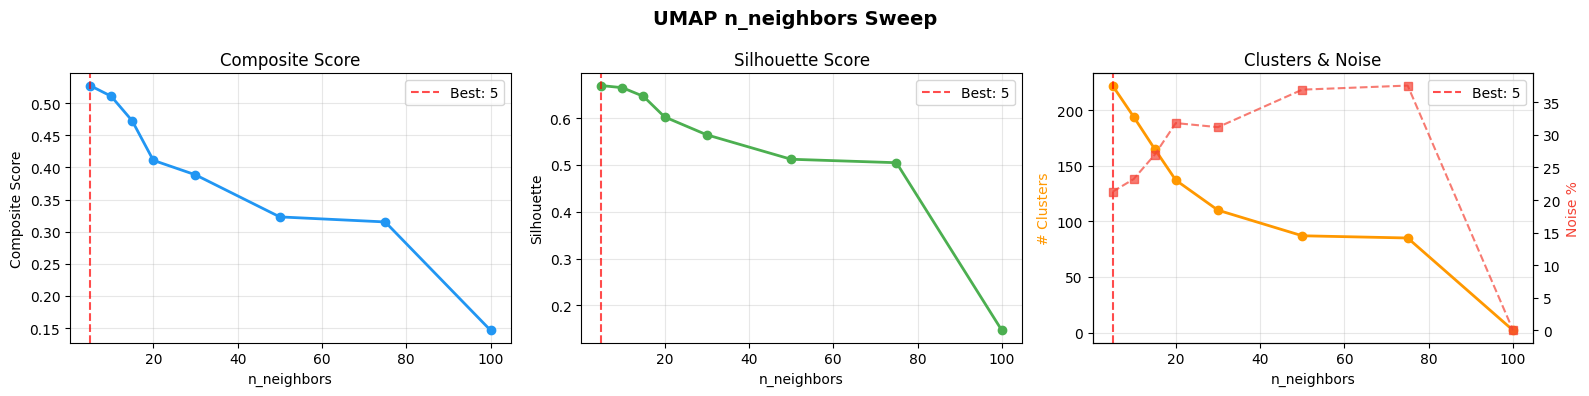

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle('UMAP n_neighbors Sweep', fontsize=14, fontweight='bold')

axes[0].plot(nn_df['n_neighbors'], nn_df['composite'], 'o-', color='#2196F3', lw=2)
axes[0].axvline(best_nn, color='red', ls='--', alpha=0.7, label=f'Best: {best_nn}')
axes[0].set_xlabel('n_neighbors'); axes[0].set_ylabel('Composite Score')
axes[0].set_title('Composite Score'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(nn_df['n_neighbors'], nn_df['silhouette'], 'o-', color='#4CAF50', lw=2)
axes[1].axvline(best_nn, color='red', ls='--', alpha=0.7, label=f'Best: {best_nn}')
axes[1].set_xlabel('n_neighbors'); axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette Score'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(nn_df['n_neighbors'], nn_df['n_clusters'], 'o-', color='#FF9800', lw=2)
ax2 = axes[2].twinx()
ax2.plot(nn_df['n_neighbors'], nn_df['noise_pct'], 's--', color='#F44336', lw=1.5, alpha=0.7)
axes[2].axvline(best_nn, color='red', ls='--', alpha=0.7, label=f'Best: {best_nn}')
axes[2].set_xlabel('n_neighbors'); axes[2].set_ylabel('# Clusters', color='#FF9800')
ax2.set_ylabel('Noise %', color='#F44336')
axes[2].set_title('Clusters & Noise'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}tuning_umap_n_neighbors.png", dpi=200, bbox_inches='tight')
plt.show()

In [6]:
# Fase 2 - Scansione 2D di min_cluster_size x min_samples per HDBSCAN, con n_neighbors fissato al valore ottimale trovato in fase 1
best_embedding = nn_embeddings[best_nn]

mcs_range = list(range(3, 31, 1))
ms_range = [1, 2, 3, 5, 7, 10, 15, 20]

grid_results = []

for mcs in mcs_range:
    for ms in ms_range:
        if ms > mcs:
            continue
        model = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms, metric='euclidean')
        labels = model.fit_predict(best_embedding)
        metrics = evaluate_clustering(best_embedding, labels)
        metrics['min_cluster_size'] = mcs
        metrics['min_samples'] = ms
        grid_results.append(metrics)

grid_df = pd.DataFrame(grid_results)
best_grid_idx = grid_df['composite'].idxmax()
best_row = grid_df.loc[best_grid_idx]
print(f"Best configuration:")
print(f"  min_cluster_size = {int(best_row['min_cluster_size'])}")
print(f"  min_samples      = {int(best_row['min_samples'])}")
print(f"  clusters         = {int(best_row['n_clusters'])}")
print(f"  noise            = {best_row['noise_pct']:.1f}%")
print(f"  silhouette       = {best_row['silhouette']:.4f}")
print(f"  composite        = {best_row['composite']:.4f}")

Best configuration:
  min_cluster_size = 4
  min_samples      = 3
  clusters         = 390
  noise            = 14.5%
  silhouette       = 0.6684
  composite        = 0.5717


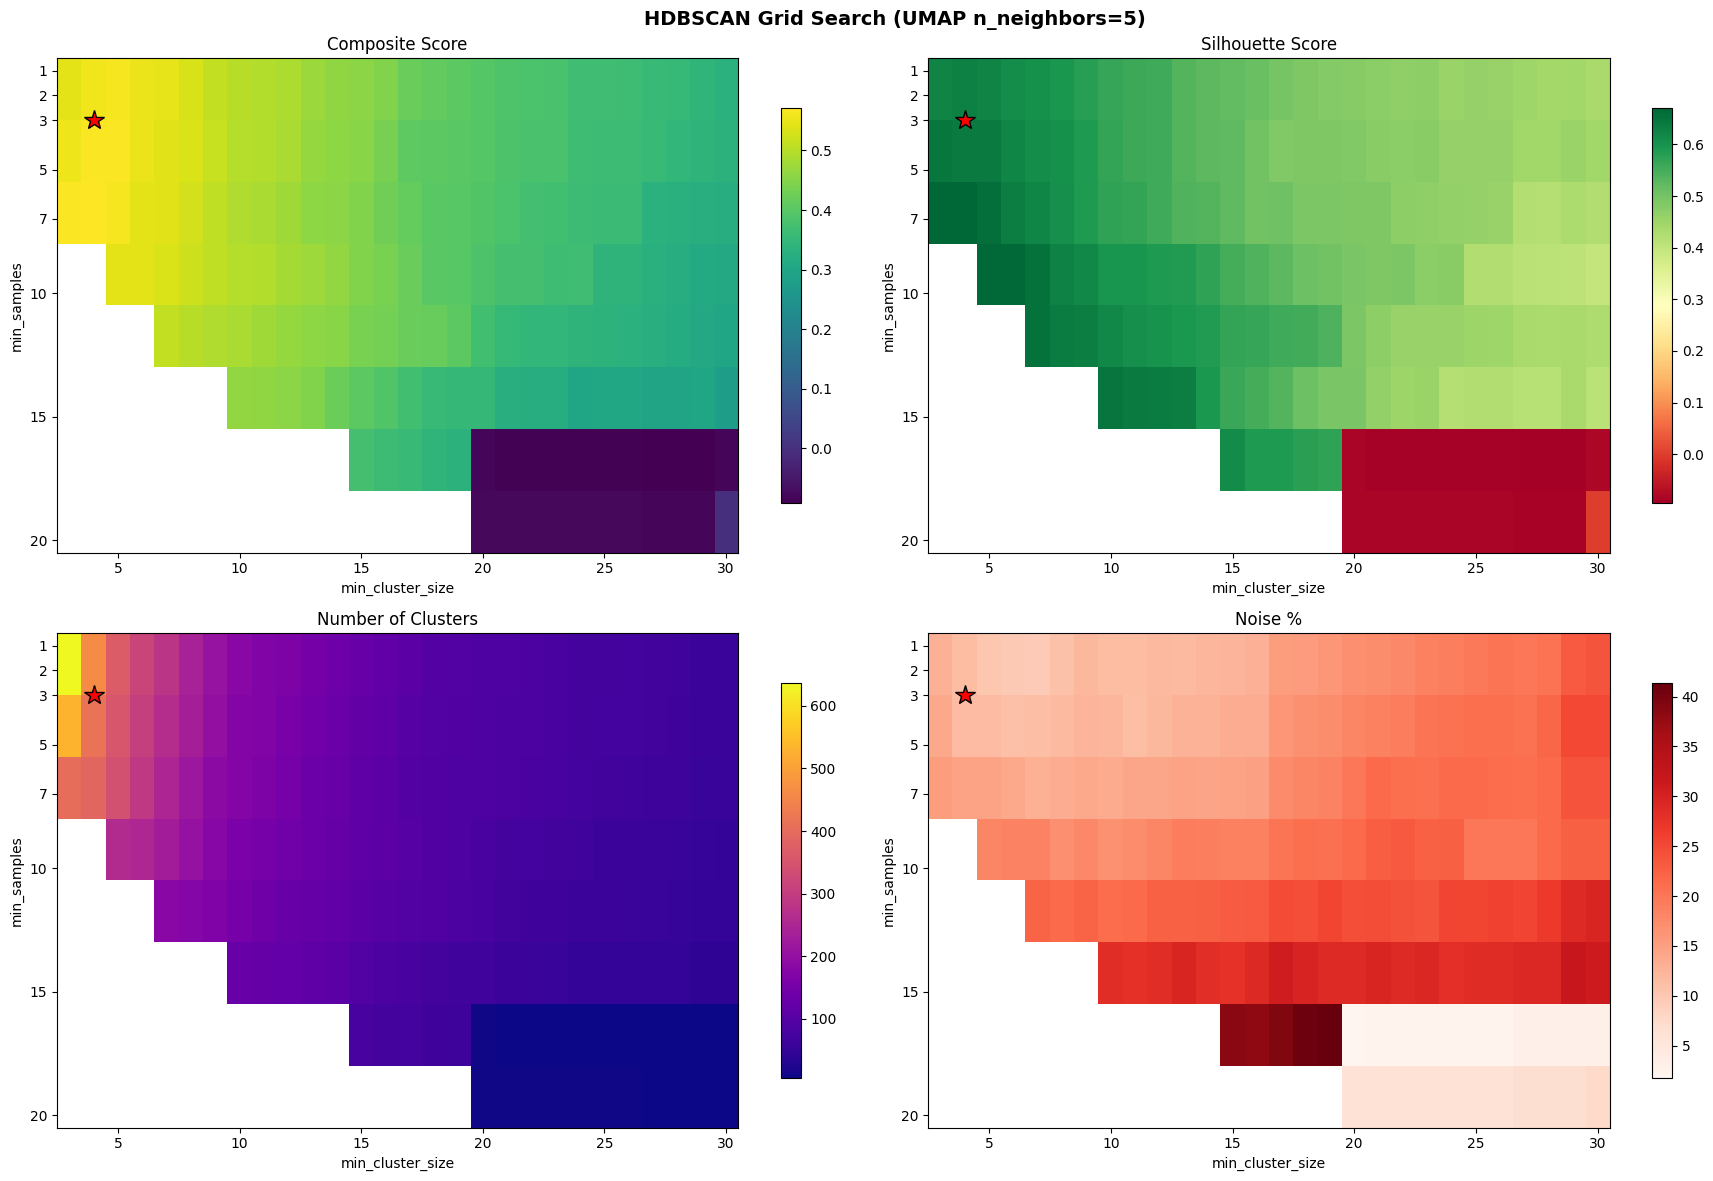

In [7]:
pivot_composite = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                      values='composite', aggfunc='first')
pivot_sil = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                values='silhouette', aggfunc='first')
pivot_nclusters = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                      values='n_clusters', aggfunc='first')
pivot_noise = grid_df.pivot_table(index='min_samples', columns='min_cluster_size',
                                  values='noise_pct', aggfunc='first')

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle(f'HDBSCAN Grid Search (UMAP n_neighbors={best_nn})', fontsize=14, fontweight='bold')

for ax, data, title, cmap in [
    (axes[0, 0], pivot_composite, 'Composite Score', 'viridis'),
    (axes[0, 1], pivot_sil, 'Silhouette Score', 'RdYlGn'),
    (axes[1, 0], pivot_nclusters, 'Number of Clusters', 'plasma'),
    (axes[1, 1], pivot_noise, 'Noise %', 'Reds'),
]:
    im = ax.imshow(data.values, aspect='auto', cmap=cmap,
                   extent=[data.columns.min()-0.5, data.columns.max()+0.5,
                           data.index.max()+0.5, data.index.min()-0.5])
    ax.set_xlabel('min_cluster_size')
    ax.set_ylabel('min_samples')
    ax.set_title(title)
    ax.set_yticks(data.index)
    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.plot(best_row['min_cluster_size'], best_row['min_samples'],
            marker='*', color='red', markersize=15, markeredgecolor='black', markeredgewidth=1)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}tuning_hdbscan_grid.png", dpi=200, bbox_inches='tight')
plt.show()

In [8]:
# Fase 3 - Confronto tra cluster_selection_method: EOM vs Leaf.
# EOM = Extracted Outliers Method, piu' conservativo, tende a produrre meno cluster ma con meno rumore
# Leaf = più aggressivo, tende a produrre più cluster ma con più rumore

best_mcs = int(best_row['min_cluster_size'])
best_ms = int(best_row['min_samples'])

method_results = []
for method in ['eom', 'leaf']:
    model = hdbscan.HDBSCAN(
        min_cluster_size=best_mcs, min_samples=best_ms,
        cluster_selection_method=method, metric='euclidean'
    )
    labels = model.fit_predict(best_embedding)
    metrics = evaluate_clustering(best_embedding, labels)
    metrics['method'] = method
    method_results.append(metrics)
    print(f"{method.upper():>4}: {metrics['n_clusters']:>3} clusters, "
          f"noise={metrics['noise_pct']:5.1f}%, sil={metrics['silhouette']:.4f}, "
          f"composite={metrics['composite']:.4f}")

method_df = pd.DataFrame(method_results)
best_method = method_df.loc[method_df['composite'].idxmax(), 'method']
print(f"\n>>> Best cluster_selection_method = '{best_method}'")

 EOM: 390 clusters, noise= 14.5%, sil=0.6684, composite=0.5717
LEAF: 416 clusters, noise= 18.4%, sil=0.6680, composite=0.5448

>>> Best cluster_selection_method = 'eom'


In [18]:
final_model = hdbscan.HDBSCAN(
    min_cluster_size=best_mcs, min_samples=best_ms,
    cluster_selection_method=best_method, metric='euclidean'
)
final_labels = final_model.fit_predict(best_embedding)
final_metrics = evaluate_clustering(best_embedding, final_labels)

print("=== Parametri ottimizzati per UMAP + HDBSCAN sul dataset ===")
print(f"UMAP n_neighbors            = {best_nn}")
print(f"HDBSCAN min_cluster_size    = {best_mcs}")
print(f"HDBSCAN min_samples         = {best_ms}")
print(f"HDBSCAN cluster_selection   = '{best_method}'")
print(f"Clusters found              = {final_metrics['n_clusters']}")
print(f"Noise                       = {final_metrics['noise_pct']:.1f}%")
print(f"Silhouette (excl. noise)    = {final_metrics['silhouette']:.4f}")
print(f"Composite score             = {final_metrics['composite']:.4f}")


=== Parametri ottimizzati per UMAP + HDBSCAN sul dataset ===
UMAP n_neighbors            = 5
HDBSCAN min_cluster_size    = 4
HDBSCAN min_samples         = 3
HDBSCAN cluster_selection   = 'eom'
Clusters found              = 390
Noise                       = 14.5%
Silhouette (excl. noise)    = 0.6684
Composite score             = 0.5717
